# 4. External Compton

In this tutorial, we will show how to compute the Spectral Energy Distribution (SED) produced by the  External Compton (EC) radiative process.

Again, we will validate `agnpy`'s results by comparing them against the literature and against another open-source blazar modeling package: [jetset](https://jetset.readthedocs.io/en/1.1.2/).

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import m_e
import pkg_resources
import matplotlib.pyplot as plt
from IPython.display import Image

In [2]:
# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.emission_regions import Blob
from agnpy.compton import ExternalCompton
from agnpy.targets import SSDisk, SphericalShellBLR, RingDustTorus
from agnpy.utils.plot import plot_sed, load_mpl_rc

load_mpl_rc()

## 4.1. External Compton emission in `agnpy`

In order to provide a cross-check with the literature, in this tutorial we will reproduce the results in [Finke (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...830...94F/abstract). Therefore we adapt an emission region with the same parameters specified in the paper. In this case we consider a broken power-law to describe the electron distribution.

In [19]:
# blob attributes
R_b = 1e16 * u.cm
B = 0.56 * u.G
z = 1
delta_D = 40
Gamma = 40

# total energy content of the electron distribution
W_e = 6e42 * u.Unit("erg")
V_b = 4 / 3 * np.pi * R_b**3

n_e = BrokenPowerLaw.from_total_energy(
    W_e,
    V_b,
    p1=2.0,
    p2=3.5,
    gamma_b=1e4,
    gamma_min=20,
    gamma_max=5e7,
    mass=m_e,
)

# emission region
blob = Blob(R_b=R_b, z=z, delta_D=delta_D, Gamma=Gamma, B=B, n_e=n_e)
blob.set_gamma_e(400)

### 4.1.1 External Compton on Dust Torus and BLR

Let us consider, as exemplary cases, EC scattering of the broad line region (BLR) and dust torus (DT) photon fields. Let us define these objects (targets) first.

In [20]:
# luminostiy of the disk being reprocessed by the BLR and DT
L_disk = 2 * 1e46 * u.Unit("erg s-1")

# broad line region definition
xi_line = 0.024
R_line = 1e17 * u.cm
blr = SphericalShellBLR(L_disk, xi_line, "Lyalpha", R_line)

# dust torus definition
xi_dt = 0.1
T_dt = 1e3 * u.K
dt = RingDustTorus(L_disk, xi_dt, T_dt)

Similarly to the synchrotron and SSC case, to initialize the object that will compute the external Compton (EC) radiation, we simply pass the Blob and the Target objects to the `ExternalCompton` class. **Note in this case the distance r between the target and the emission region (in `astropy.units`) also has to be specified,** as the scattering will also depend on the distance between the electrons and the target photon fields. We will illustrate this effect, let us start very close to the BLR.

In [21]:
r = 2 * R_line

ec_blr_near = ExternalCompton(blob, blr, r)
ec_dt_near = ExternalCompton(blob, dt, r)

Let us compute the SEDs and plot them.

In [22]:
nu = np.logspace(15, 30, 40) * u.Hz

sed_ec_blr_near = ec_blr_near.sed_flux(nu)
sed_ec_dt_near = ec_dt_near.sed_flux(nu)

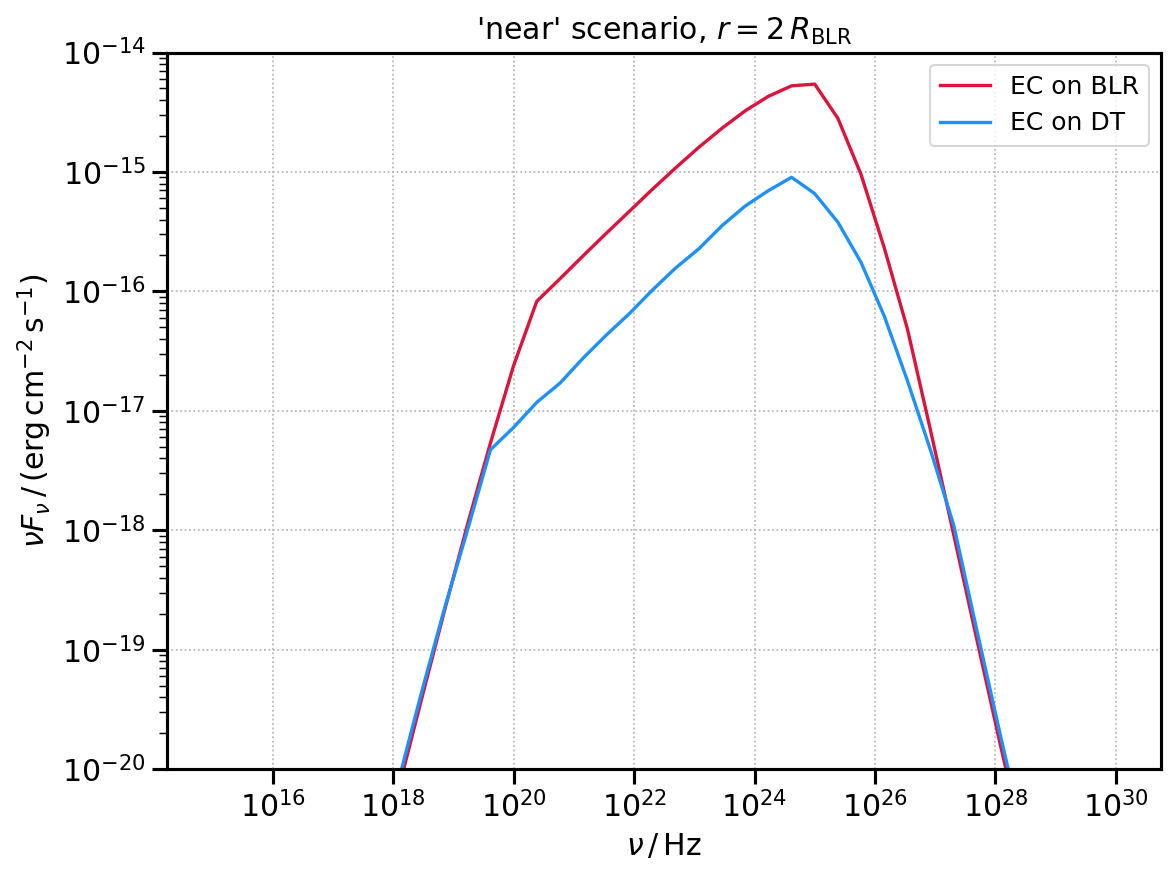

In [23]:
plot_sed(nu, sed_ec_blr_near, color="crimson", label="EC on BLR")
plot_sed(nu, sed_ec_dt_near, color="dodgerblue", label="EC on DT")
plt.title("'near' scenario, " + r"$r = 2\,R_{\rm BLR}$")
plt.ylim([1e-20, 1e-14])
plt.show()

Let us move the blob further away from the BLR and recompute the EC scattering SED.

In [24]:
r = 20 * R_line

ec_blr_far = ExternalCompton(blob, blr, r)
ec_dt_far = ExternalCompton(blob, dt, r)

sed_ec_blr_far = ec_blr_far.sed_flux(nu)
sed_ec_dt_far = ec_dt_far.sed_flux(nu)

print(f"distance in DT radii: {r / dt.R_dt}")

distance in DT radii: 0.12777531299998798


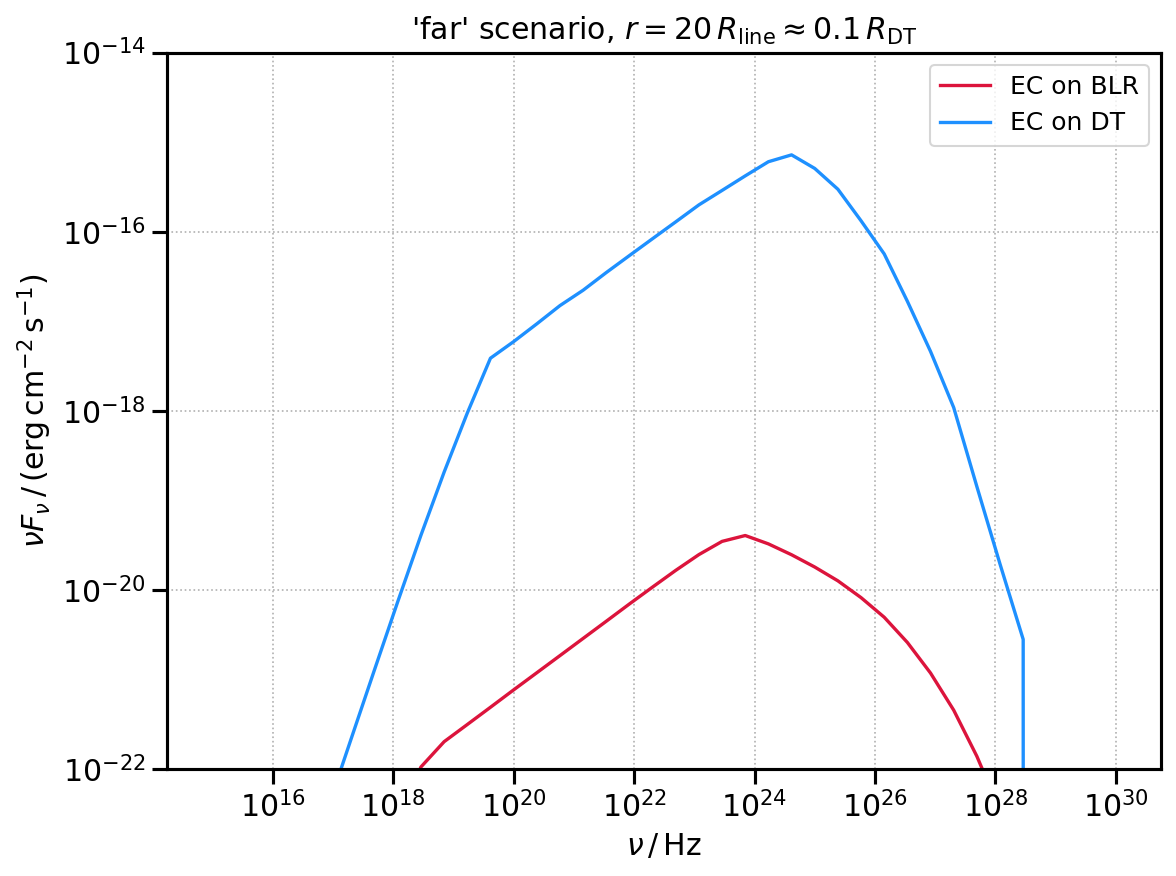

In [25]:
plot_sed(nu, sed_ec_blr_far, color="crimson", label="EC on BLR")
plot_sed(nu, sed_ec_dt_far, color="dodgerblue", label="EC on DT")
plt.title("'far' scenario, " + r"$r = 20\,R_{\rm line} \approx 0.1\,R_{\rm DT}$")
plt.ylim([1e-22, 1e-14])
plt.show()

## 4.2. Validation: compare the result of `agnpy` against the literature and `JetSet`

In order to validate `agnpy` we can compare the results of its calculations against the literature and against other software. We choose the EC on DT for validation.

For what concerns the literature, we choose to reproduce one of the curves, the one at $r=10^{18}\,{\rm cm}$, in Figure 11 of [Finke (2016)](https://ui.adsabs.harvard.edu/abs/2016ApJ...830...94F/abstract).

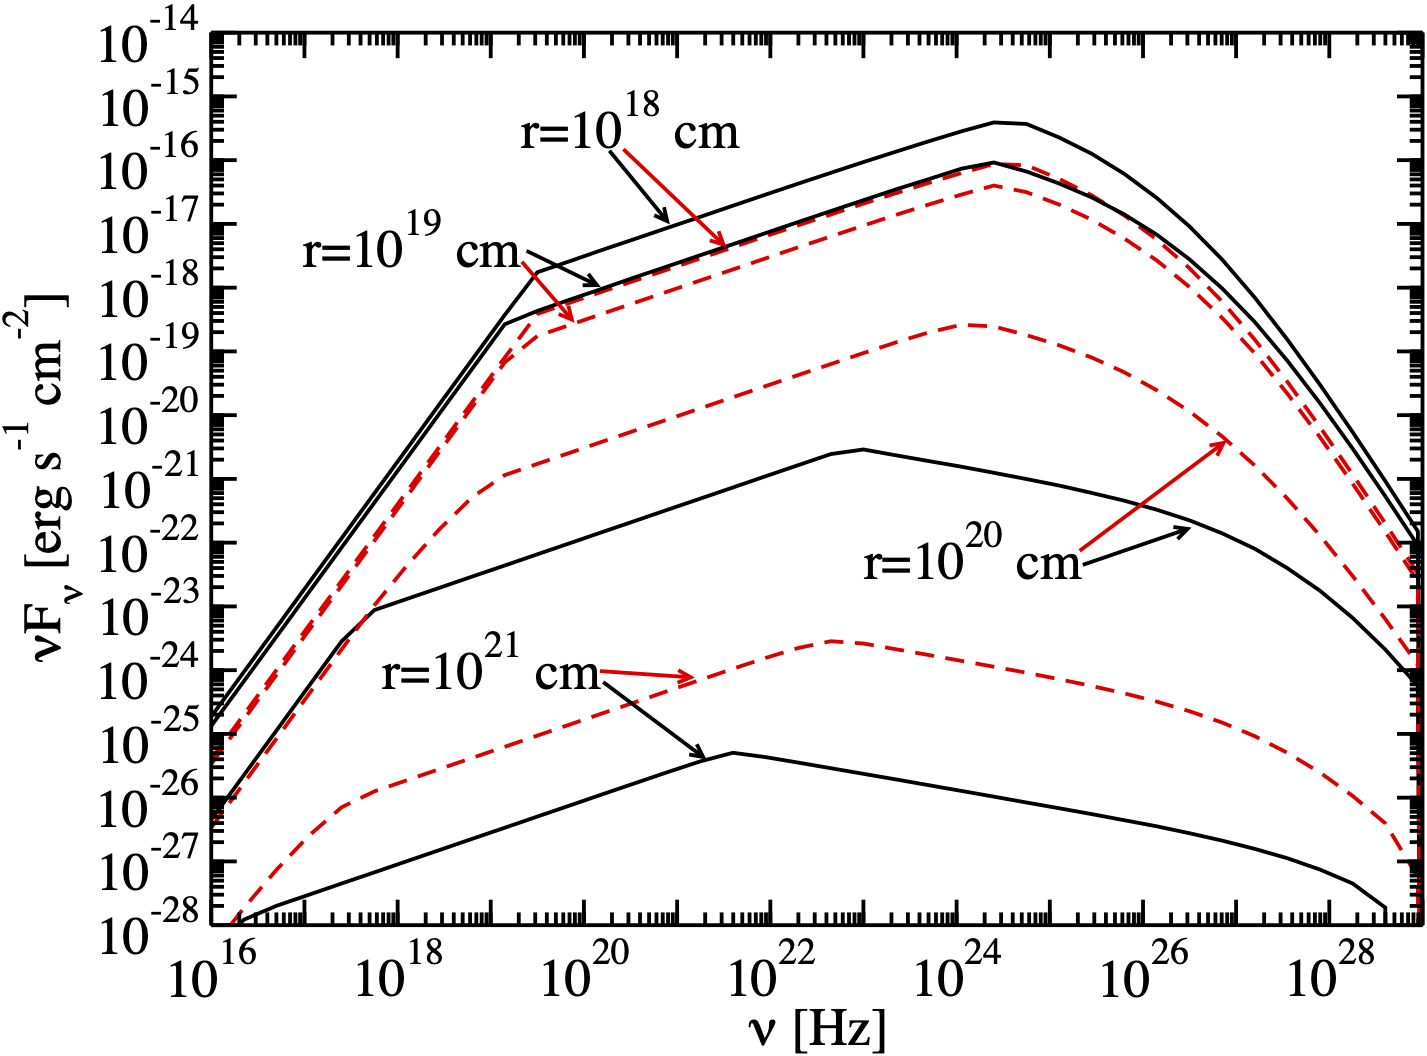

In [26]:
url = "https://raw.githubusercontent.com/cosimoNigro/agnpy/master/docs/tutorials/figures/figure_11_finke_2016.png"
Image(url, width=800, height=600)

Compute the EC on DT at $r=10^{18}\,{\rm cm}$ with agnpy:

In [27]:
r = 1e18 * u.cm

ec_dt = ExternalCompton(blob, dt, r)
sed_ec_dt = ec_dt.sed_flux(nu)

To make a comparison against another software, we use the same emission region parameters to compute EC on DT emission with `JetSet`.

In [28]:
# jetset
from jetset.jet_model import Jet

jet = Jet(
    name="ec_dt",
    electron_distribution="bkn",
    electron_distribution_log_values=False,
    beaming_expr="bulk_theta",
)
jet.add_EC_component(["EC_DT"])

# - blob
jet.set_par("N", val=blob.n_e_tot.value)
jet.set_par("p", val=blob.n_e.p1)
jet.set_par("p_1", val=blob.n_e.p2)
jet.set_par("gamma_break", val=blob.n_e.gamma_b)
jet.set_par("gmin", val=blob.n_e.gamma_min)
jet.set_par("gmax", val=blob.n_e.gamma_max)
jet.set_par("R", val=blob.R_b.value)
jet.set_par("B", val=blob.B.value)
jet.set_par("BulkFactor", val=blob.Gamma)
jet.set_par("theta", val=blob.theta_s.value)
jet.set_par("z_cosm", val=blob.z)

# - DT
jet.set_par("L_Disk", val=L_disk.value)
jet.set_par("tau_DT", val=dt.xi_dt)
jet.set_par("R_DT", val=dt.R_dt.value)
jet.set_par("T_DT", val=dt.T_dt.value)

# - integration setup
jet.electron_distribution.update()
jet.set_gamma_grid_size(10000)
jet._blob.IC_adaptive_e_binning = True
jet._blob.theta_n_int = 500
jet.set_nu_grid(nu[0].value, nu[-1].value, len(nu))

# - SED near the DT
jet.set_par("R_H", val=r.to_value("cm"))
jet.set_external_field_transf("disk")
# fixes by Andrea to reproduce Finke's approach
jet._blob.R_H_scale_factor = 50
jet._blob.R_ext_factor = 0.5
theta_lim = np.rad2deg(np.arctan(jet.get_beaming() / jet.parameters.BulkFactor.val))
jet._blob.EC_theta_lim = theta_lim

jet.eval()

nu_ec_dt_jetset = jet.spectral_components.SSC.SED.nu
sed_ec_dt_jetset = jet.spectral_components.EC_DT.SED.nuFnu

/Users/cosimo/software/miniconda3/envs/gammapy-1.0/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


The numerical values of the SED in the reference figure are stored in the `agnpy` resources.

In [29]:
# load the SED from the reference figure
ec_dt_finke = pkg_resources.resource_filename(
    "agnpy",
    "data/reference_seds/finke_2016/figure_11/ec_dt_r_1e18.txt",
)

data_ec_dt_finke = np.loadtxt(ec_dt_finke, delimiter=",")

nu_ec_dt_finke = data_ec_dt_finke[:, 0] * u.Hz
sed_ec_dt_finke = data_ec_dt_finke[:, 1] * u.Unit("erg cm-2 s-1")

We then produce a final validation plot.

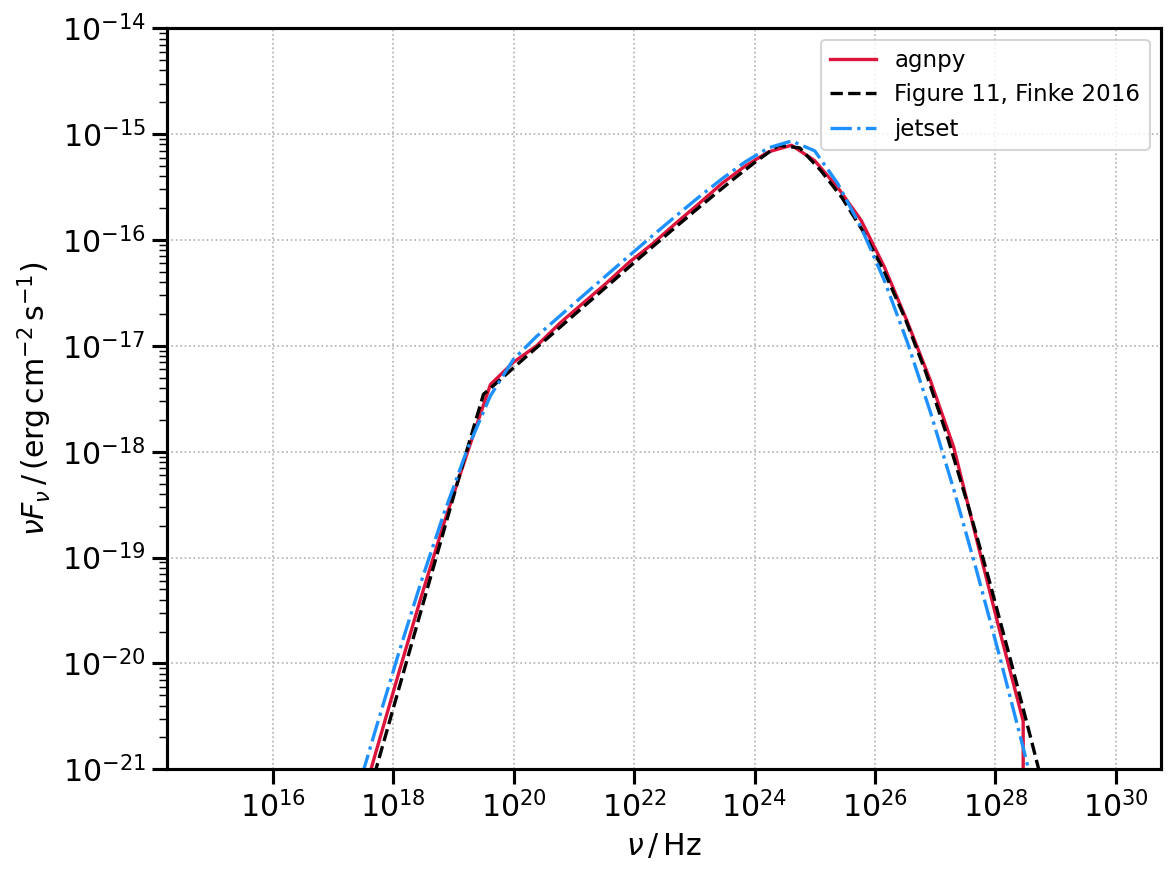

In [30]:
plot_sed(
    nu,
    sed_ec_dt,
    color="crimson",
    label="agnpy",
)
plot_sed(
    nu_ec_dt_finke, sed_ec_dt_finke, color="k", ls="--", label="Figure 11, Finke 2016"
)
plot_sed(nu_ec_dt_jetset, sed_ec_dt_jetset, color="dodgerblue", ls="-.", label="jetset")

plt.legend(fontsize=11)
plt.ylim([1e-21, 1e-14])
plt.show()

## 4.3. Exercises

### 4.3.1 Approximating the DT with a point-like monochromatic source

For a distance much larger than the dust torus radius, $r=10^{22}\,{\rm cm}$, produce the SED for EC on a point-like source approximating it (see previous exercise), and check if the latter 

What happens if we reduce the distance to $r=10^{21}\,{\rm cm}$, is the approximation still valid?